In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from scipy.integrate import odeint
from scipy.optimize import minimize
import scipy.stats as st
from scipy import integrate
from lmfit import minimize, Parameters, Parameter, report_fit
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
import seaborn as sns

pathName = os.getcwd()
print(pathName)

import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter

packageNames = ('Interpol', 'tidyverse')
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]

if len(packnames_to_install) > 0:
    utils.install_packages(StrVector(packnames_to_install))
    
print("Running on Pandas v{}".format(pd.__version__))

C:\Users\frank\iGEM


C:\Users\frank\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Running on Pandas v1.1.0


# Instantiate R Source and Clean Data

In [2]:
robjects.r.source("ProteinPreprocessing.R")
print(robjects.globalenv["AAindex"])

                                                                                                                                                          name

1                                                                                                             alpha-CH_chemical_shifts_(Andersen_et_al.,_1992)

2                                                                                                                    Hydrophobicity_index_(Argos_et_al.,_1982)

3                                                                                                       Signal_sequence_helical_potential_(Argos_et_al.,_1982)

4                                                                                                   Membrane-buried_preference_parameters_(Argos_et_al.,_1982)

5                                                                                                 Conformational_parameter_of_inner_helix_(Beghin-Dirkx,_1975)

6                                       

In [3]:
class_dat = robjects.globalenv["AAindex"]

# 0 is names, 1 is A, 2 is R, etc.
# print(class_dat[1]) is the same thing as
# print(class_dat.rx2("A"))

# There's 533 indices in total
print(len(class_dat[0]))
print(class_dat[0])
len_aaindex = len(class_dat[0])

533
  [1] alpha-CH_chemical_shifts_(Andersen_et_al.,_1992)                                                                                                          

  [2] Hydrophobicity_index_(Argos_et_al.,_1982)                                                                                                                 

  [3] Signal_sequence_helical_potential_(Argos_et_al.,_1982)                                                                                                    

  [4] Membrane-buried_preference_parameters_(Argos_et_al.,_1982)                                                                                                

  [5] Conformational_parameter_of_inner_helix_(Beghin-Dirkx,_1975)                                                                                              

  [6] Conformational_parameter_of_beta-structure_(Beghin-Dirkx,_1975)                                                                                           

  [7] Conformational_par

In [4]:
feature_strings = []
for i in class_dat.rx2("name"):#.levels:
    feature_strings.append(i)

# Since the rpy2 outputs a VectorString
# we have to do some work to convert it back
out_strings = []
for k in sorted(feature_strings):
    out_strings.append(class_dat.rx2("name").levels[class_dat.rx2("name")[k-1]-1])

# The index corresponds to the i+1 index in the class_dat.rx2("name") list
print(out_strings[0])

alpha-CH_chemical_shifts_(Andersen_et_al.,_1992)


In [5]:
# Open Cov-AbDab Database
url = "https://raw.githubusercontent.com/Frankdag20/harvard-igem-2020/master/CoV-AbDab_120720.csv"
df = pd.read_csv(url, index_col=0)

temp = df['CDRH3']
cdrh3 = []
for i in range(len(temp)):
    if temp[i] != 'ND':
        cdrh3.append(temp[i])
        
print(len(cdrh3))

1378


In [6]:
rstring="""
    function(desiredLength, data, lengthAAindex, descrip) {

      newDat <- matrix(nrow=length(dat), 
                   ncol=desiredLength)
  
      for (i in 1:length(dat)) {
        # AAdescriptor encodes sequences
        # Interpol normalizes to desiredLength
    
        newDat[i,] <- Interpol(AAdescriptor(dat[i], descriptor = descrip), dims = desiredLength)
      }
  
      # Extract rows with NA values
      X <- which(is.na(newDat), arr.ind = TRUE)
      Y <- X[1:nrow(X), 1]
      # Remove repeats and remove those in corresponding lists
      Z <- unique(Y)
      bindDatRem <- bindDat[-Z]
      neutrDatRem <- neutrDat[-Z]
      frameDat <- na.omit(newDat)
      writeOutput <- data.frame(frameDat, bindingData = bindDatRem, neutralizationData = neutrDatRem)
  
      return(writeOutput)
}
"""
rfunc=robjects.r(rstring)

rdata = cdrh3
des_length = 15
descrip = 1
len_aaindex = len(class_dat[0])

In [7]:
# Initialize a root array where each index is a different feature
# such as hydrophobicity, hydropathy, etc.
root_array = []

for i in range(20):
    
    # Run rfun and assign to r_df
    r_df=rfunc(des_length, rdata, len_aaindex, i+1)
    
    # Initialize iteration_array to store each amino acid column
    # in the iteration
    iteration_array = []
    for k in range(len(r_df)-1):
        # Initialize temp array to store each value in the column
        temp = []
        for j in r_df.rx(k+1):
            temp.append(j)
        iteration_array.append(temp)
    root_array.append(iteration_array)

In [132]:
feature_values = []
for i in range(20):
    iter_array = []
    for j in range(15):
        tmp = []
        for k in root_array[i][j][0]:
            tmp.append(k)
        iter_array.append(tmp)
    feature_values.append(iter_array)

In [240]:
# This is the 0th index (alpha-CH chemical shifts), and the 12th residue position of the normalized 15-length sequence
print(feature_values[0][12])

[3.95, 4.7057142857142855, 3.8714285714285723, 3.8714285714285723, 3.8914285714285723, 3.8714285714285723, 4.305714285714285, 4.611428571428571, 4.592857142857143, 4.66, 4.722857142857142, 4.66, 4.622857142857143, 4.282857142857143, 4.574285714285713, 3.848571428571429, 4.602857142857143, 4.577142857142857, 4.588571428571429, 3.848571428571429, 4.305714285714285, 4.864285714285714, 4.75, 4.722857142857142, 4.394285714285714, 4.305714285714285, 4.592857142857143, 4.394285714285714, 4.0600000000000005, 4.864285714285714, 4.394285714285714, 4.305714285714285, 4.305714285714285, 4.394285714285714, 4.314285714285713, 4.7057142857142855, 4.394285714285714, 4.577142857142857, 4.677142857142858, 4.13142857142857, 4.394285714285714, 4.574285714285715, 5.45, 4.17, 4.66, 4.305714285714285, 4.314285714285713, 4.622857142857143, 4.764285714285714, 4.382857142857143, 4.574285714285713, 4.394285714285714, 3.7357142857142853, 3.9171428571428573, 4.408571428571429, 4.277142857142858, 5.054285714285714,

In [77]:
print(len(root_array[19]))
print(root_array[0][12][0].rx(1000))

16
[1] 4.828571



In [79]:
r_df.rx("neutralizationData")

neutralizationData
0.000000
1.000000
1.000000
1.000000
...
0.000000
0.000000
0.000000
0.000000


In [88]:
neutrDat = []
for i in r_df.rx("neutralizationData"):
    for k in list(i):
        neutrDat.append(k)
    
print(neutrDat[0:6])

[0.0, 1.0, 1.0, 1.0, 1.0, 0.0]


In [267]:
# We must transform the feature_values array
# To be an array of 1334 lists of the values of each residue
# Rather than 15 lists of 1334 values of each AAIndex
feature_aaindex_values = []
for i in range(20):
    diff_index = []
    for m in range(len(feature_values[i][0])):
        residue = []
        for k in range(15):
            residue.append(feature_values[i][k][m])
        diff_index.append(residue)
        
    feature_aaindex_values.append(diff_index)
    
print(feature_aaindex_values[1])

[[0.61, 0.6, 0.07, 0.61, 2.22, 1.95, 1.95, 0.06, 0.05, 0.6, 0.61, 0.47, 2.22, 0.46, 1.88], [0.61, -0.06857142857142873, 1.14, 1.2550000000000003, 2.894285714285714, 0.7235714285714288, 0.05000000000000001, 0.04000000000000001, -0.7657142857142862, 2.0700000000000003, 2.4000000000000012, -0.4950000000000026, 2.7399999999999998, 2.131428571428571, 1.95], [0.61, -0.6342857142857143, 2.01, 2.516428571428571, 1.7985714285714287, 0.05000000000000001, -1.1899999999999995, 3.305, -0.3871428571428574, 1.4307142857142865, -0.054285714285714604, 0.5435714285714289, -0.20857142857142758, 2.131428571428571, 2.22], [0.61, -0.6342857142857143, 2.01, 2.516428571428571, 1.7985714285714287, 0.05000000000000001, -1.1899999999999995, 3.305, -0.3871428571428574, 1.4307142857142865, -0.054285714285714604, 0.5435714285714289, -0.20857142857142758, 2.131428571428571, 2.22], [0.61, 1.6514285714285712, 0.6099999999999999, 1.0499999999999998, 0.05000000000000001, 0.03714285714285714, -0.23857142857142843, 0.915,

# Produce and Assign Features

In [197]:
# Labels are values we predict

labels = np.array(neutrDat)

# We can now get feature list
feature = pd.DataFrame()

j = 0
for i in out_strings[0:20]:
    insert = []
    for k in feature_aaindex_values[j]:
        insert.append(k)
    feature[i] = insert
    j = j + 1

# Save names
feature_list = list(feature.columns)

# Convert to np array
features = np.array(feature)

print(feature)

       alpha-CH_chemical_shifts_(Andersen_et_al.,_1992)  \
0     [4.35, 4.38, 3.97, 4.35, 3.95, 4.44, 4.44, 4.7...   
1     [4.35, 4.779285714285715, 3.761428571428572, 3...   
2     [4.35, 4.266428571428571, 4.302857142857144, 4...   
3     [4.35, 4.266428571428571, 4.302857142857144, 4...   
4     [4.35, 4.3692857142857155, 4.1099999999999985,...   
...                                                 ...   
1369  [4.35, 4.191428571428572, 4.7785714285714285, ...   
1370  [4.35, 4.191428571428572, 4.7785714285714285, ...   
1371  [4.35, 4.341428571428571, 4.614285714285714, 3...   
1372  [4.35, 4.339285714285714, 4.38, 4.38, 4.221428...   
1373  [4.35, 4.191428571428572, 4.7785714285714285, ...   

              Hydrophobicity_index_(Argos_et_al.,_1982)  \
0     [0.61, 0.6, 0.07, 0.61, 2.22, 1.95, 1.95, 0.06...   
1     [0.61, -0.06857142857142873, 1.14, 1.255000000...   
2     [0.61, -0.6342857142857143, 2.01, 2.5164285714...   
3     [0.61, -0.6342857142857143, 2.01, 2.5164285714...

In [277]:
feature_flat = pd.DataFrame()

p = 0
for i in range(20):
    g = 0
    insert = [0]*1374
    for k in feature_aaindex_values[i]:
        for j in range(15):
            insert[g] = k[j]
        g = g + 1
    for h in range(15):
        feature_flat[p] = insert
        p = p + 1
print(feature_flat)

       0     1     2     3     4     5     6     7     8     9    ...   290  \
0     4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   
1     4.44  4.44  4.44  4.44  4.44  4.44  4.44  4.44  4.44  4.44  ...  0.34   
2     3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  ...  0.41   
3     3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  ...  0.41   
4     3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  3.95  ...  0.50   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1369  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   
1370  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   
1371  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   
1372  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   
1373  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  4.60  ...  0.43   

       291   292   293   294   295   296   297   29

# Use PCA to Reduce Dimensionality of Data

In [279]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
x = feature_flat.iloc[:, 0:300].values

# Separating out the target
y = labels
# Standardizing the features
x = StandardScaler().fit_transform(x)
print(x)

[[ 0.83902821  0.83902821  0.83902821 ...  0.15831843  0.15831843
   0.15831843]
 [ 0.30937433  0.30937433  0.30937433 ... -1.24812246 -1.24812246
  -1.24812246]
 [-1.31269065 -1.31269065 -1.31269065 ... -0.15422399 -0.15422399
  -0.15422399]
 ...
 [ 0.83902821  0.83902821  0.83902821 ...  0.15831843  0.15831843
   0.15831843]
 [ 0.83902821  0.83902821  0.83902821 ...  0.15831843  0.15831843
   0.15831843]
 [ 0.83902821  0.83902821  0.83902821 ...  0.15831843  0.15831843
   0.15831843]]


Check that every feature is now centered and has unit variance

In [280]:
p  = x.shape[1]
pr = range(p)
print("Max absolute mean {0:.3e}".format(np.max([np.abs(x[:, i].mean()) for i in pr])))
print("Min variance {0:.3f}".format(np.min([x[:, i].var() for i in pr])))
print("Max variance {0:.3f}".format(np.max([x[:, i].var() for i in pr])))

Max absolute mean 2.555e-15
Min variance 1.000
Max variance 1.000


In [284]:
from sklearn.decomposition import PCA

pca = PCA()
data_pca = pca.fit_transform(x)

Differences should be near 0

In [286]:
data_recovered = pca.inverse_transform(data_pca)
difference = (x-data_recovered)
print("Max abs difference {0:.2e}".format(np.max(np.abs(difference))))
print("Norm difference {0:.2e}".format(np.linalg.norm(difference)))

Max abs difference 1.67e-13
Norm difference 2.48e-12


In [287]:
data_pca[:,8]@data_pca[:,54]
# For np.cov, rowvar needs to be False.
# If rowvar=True, it means that rows are the variables, and columns are observations.
# In this case, however, columns are the variables.
np.count_nonzero(np.around([np.cov(data_pca, rowvar=False) - np.diag(np.diagonal(np.cov(data_pca, rowvar=False)))], decimals=10))

0

In [289]:
i, j = 3, 7 # Arbitrary indices
print("Dot prod ({0}, {1}): {2:.2e}".format(i, j, np.dot(data_pca[:, i], data_pca[:, j])))
print("\nCovariance matrix:")
C = np.cov(data_pca, rowvar=False)
print(np.round(C, 1))
# Show that the off-diagonal components are tiny
for i in range(C.shape[1]):
    C[i, i] = 0

# This is tiny showing that C is effectively just a diagonal matrix.
print("\nNorm of C without diag: {0:.2e}".format(np.linalg.norm(C)))

Dot prod (3, 7): 9.38e-13

Covariance matrix:
[[135.9  -0.    0.  ...  -0.    0.    0. ]
 [ -0.   62.7  -0.  ...  -0.    0.   -0. ]
 [  0.   -0.   45.2 ...  -0.   -0.    0. ]
 ...
 [ -0.   -0.   -0.  ...   0.    0.   -0. ]
 [  0.    0.   -0.  ...   0.    0.    0. ]
 [  0.   -0.    0.  ...  -0.    0.    0. ]]

Norm of C without diag: 1.57e-13


In [306]:
columns = ['PC{}'.format(i+1) for i in range(data_pca.shape[1])]

# Create loadings
loadings = pd.DataFrame(data=pca.components_,columns=feature_flat.columns,index=columns)
loadings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
PC1,0.067109,0.067109,0.067109,0.067109,0.067109,0.067109,0.067109,0.067109,0.067109,0.067109,...,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768,-0.037768
PC2,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,-0.060683,...,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802,-0.002802
PC3,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,-0.014301,...,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433,-0.073433
PC4,0.068946,0.068946,0.068946,0.068946,0.068946,0.068946,0.068946,0.068946,0.068946,0.068946,...,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861,-0.111861
PC5,0.020795,0.020795,0.020795,0.020795,0.020795,0.020795,0.020795,0.020795,0.020795,0.020795,...,0.012551,0.012551,0.012551,0.012551,0.012551,0.012551,0.012551,0.012551,0.012551,0.012551


<AxesSubplot:>

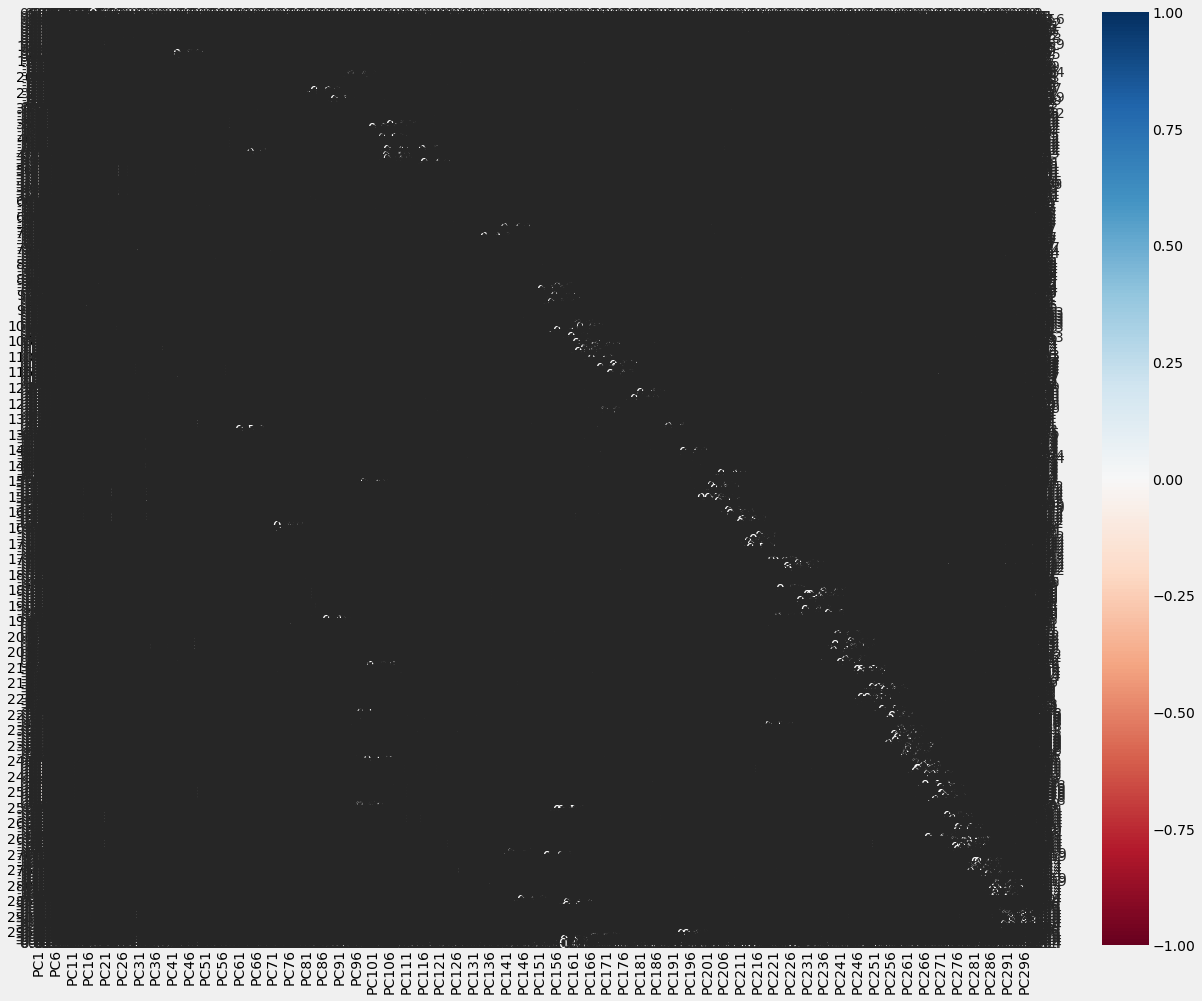

In [341]:
plt.figure(figsize=(20, 16))
sns.heatmap(
        loadings.transpose(),
        linewidths=0.5, 
        cmap="RdBu", vmin=-1, vmax=1, annot=True)

<AxesSubplot:>

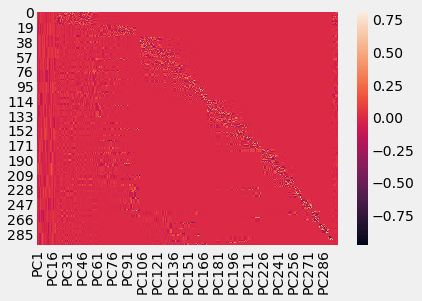

In [340]:
sns.heatmap(loadings.T)

# Training and Test Sets

In [309]:
# Use Skicit-learn to split data
from sklearn.model_selection import train_test_split

# Split the data
# Use train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(feature_flat, labels, 
                                                                            test_size = 0.25, random_state = 42)

pca.fit(train_features)
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1030, 300)
Training Labels Shape: (1030,)
Testing Features Shape: (344, 300)
Testing Labels Shape: (344,)


# Train Model

In [311]:
# Import random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Classification to the Training set
#classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
#classifier.fit(train_features, train_labels)

# Begin model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

# Predict

In [312]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
predictions_fit = rf.predict(train_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print(predictions)

Mean Absolute Error: 0.26 degrees.
[0.16380051 0.13996309 0.192173   0.18739655 0.13996309 0.
 0.18739655 0.18739655 0.04741014 0.13996309 0.13996309 0.13996309
 0.13996309 0.13996309 0.17958218 0.13996309 0.13996309 0.13996309
 0.17958218 0.08780962 0.18739655 0.13996309 0.13996309 0.18739655
 0.13996309 0.18739655 0.192173   0.13996309 0.13996309 0.18739655
 0.13996309 0.17958218 0.13996309 0.04741014 0.18739655 0.13996309
 0.18739655 0.18739655 0.13996309 0.18739655 0.13996309 0.04741014
 0.13996309 0.08780962 0.18739655 0.13996309 0.13996309 0.13996309
 0.13996309 0.17958218 0.13996309 0.20528123 0.04741014 0.18739655
 0.13996309 0.13996309 0.         0.20528123 0.18739655 0.16380051
 0.13996309 0.18739655 0.13996309 0.         0.13996309 0.18739655
 0.13996309 0.13996309 0.18739655 0.13996309 0.13996309 0.13996309
 0.17958218 0.17958218 0.13996309 0.13996309 0.13996309 0.192173
 0.13996309 0.18739655 0.13996309 0.13996309 0.16671418 0.20528123
 0.18739655 0.192173   0.17958218 0.2

In [337]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(test_labels,predictions))

MSE = np.square(np.subtract(test_labels,predictions)).mean()

print(MSE)

0.13159122912991825
0.13159122912991825


# Extract Important Features

In [315]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Signal_sequence_helical_potential_(Argos_et_al.,_1982) Importance: 0.16
Variable: Conformational_parameter_of_beta-structure_(Beghin-Dirkx,_1975) Importance: 0.12
Variable: Hydrophobicity_index_(Argos_et_al.,_1982) Importance: 0.11
Variable: Conformational_parameter_of_inner_helix_(Beghin-Dirkx,_1975) Importance: 0.11
Variable: alpha-CH_chemical_shifts_(Andersen_et_al.,_1992) Importance: 0.09
Variable: Membrane-buried_preference_parameters_(Argos_et_al.,_1982) Importance: 0.08
Variable: alpha-CH_chemical_shifts_(Bundi-Wuthrich,_1979) Importance: 0.07
Variable: Residue_volume_(Bigelow,_1967) Importance: 0.03
Variable: Information_value_for_accessibility;_average_fraction_35%_(Biou_et_al.,_1988) Importance: 0.03
Variable: Information_value_for_accessibility;_average_fraction_23%_(Biou_et_al.,_1988) Importance: 0.03
Variable: Retention_coefficient_in_TFA_(Browne_et_al.,_1982) Importance: 0.03
Variable: alpha-NH_chemical_shifts_(Bundi-Wuthrich,_1979) Importance: 0.03
Variable: Av

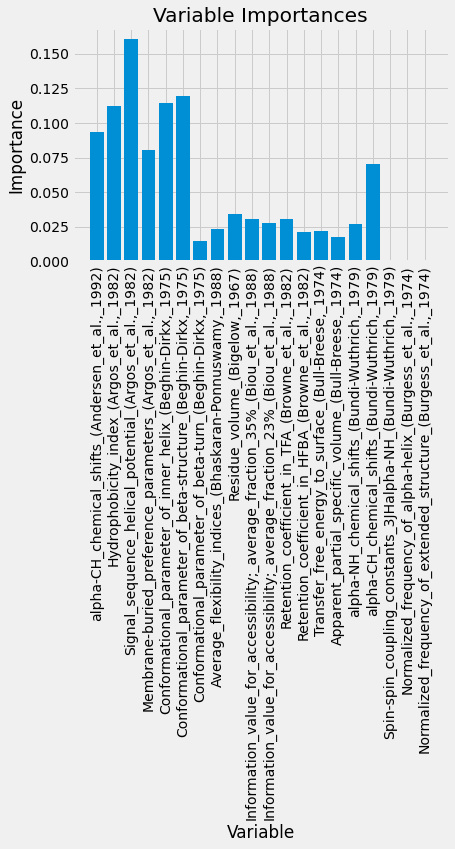

In [327]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values[0:20], importances[0:20], orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values[0:20], feature_list[0:20], rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 